In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
#import numba as nb

from scipy.integrate import quad   # integración mediante funciones
from scipy.integrate import simps  # integración mediante datos
from scipy.interpolate import CubicSpline
from scipy.misc import derivative  # para calcular derivada numerica

Código donde se calcula el disco de acreción, las unidades usadas son:

- masa de la partícula en: $10^{-19} eV$
- el flujo se da en: erg $s^{-1}cm^{-2}$
- la temperatura en: $K$
- $\dot{M}$ en Masas solares por año
- $\sigma = 5.67*10^{-5}$ erg $s^{-1} cm^{-2} K^{-4}$
- $h = 6.6256*10^{-27}$ erg s
- $k = 1.3805*10^{-16}$ erg $K^{-1}$

las ecuaciones son las basadas en arxiv : 1009.1250 v1

In [2]:
# importando perfiles
g = np.loadtxt("g_profile.dat", unpack= True)
dg = np.loadtxt("dg_profile.dat", unpack= True)

N = np.loadtxt('N_profile.dat', unpack= True)
dN = np.loadtxt('dN_profile.dat', unpack= True)
ddN = np.loadtxt('ddN_profile.dat', unpack= True)

In [3]:
# interpolando perfiles

f_g = CubicSpline(g[0], g[1], bc_type='natural')
f_dg = CubicSpline(dg[0], dg[1], bc_type='natural')

f_N = CubicSpline(N[0], N[1], bc_type='natural')
f_dN = CubicSpline(dN[0], dN[1], bc_type='natural')
f_ddN = CubicSpline(ddN[0], ddN[1], bc_type='natural')

perfiles = [f_g, f_dg, f_N, f_dN, f_ddN]

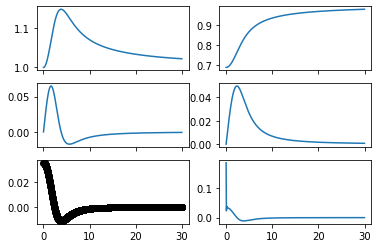

In [4]:
# plots checking

rad = np.arange(g[0][0], 30, 0.01)# g[0][-1]

fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=False)

ax[0,0].plot(rad, f_g(rad), label='g_profile')
ax[1,0].plot(rad, f_dg(rad), label='dg_profile')

ax[0,1].plot(rad, f_N(rad), label='N_profile')
ax[1,1].plot(rad, f_dN(rad), label='dN_profile')
ax[2,1].plot(rad, f_ddN(rad), label='ddN_profile')

for i in rad:
    ax[2,0].plot(i, derivative(f_dN, i, dx=1e-6), 'ko')
    #ax[1,1].plot(i, derivative(f_N, i, dx=1e-6), 'k^')
    

In [4]:
# definiendo cantidades físicas

def Sigma(r, per=perfiles):
    
    g, dg, N, dN, ddN = per  # asignando perfiles
    
    sig = np.sqrt(r*N(r)*dN(r))/r
    
    return sig 

def dSigma(r, per=perfiles):
    
    g, dg, N, dN, ddN = per  # asignando perfiles
    
    d2N = derivative(dN, r, dx=1e-6)
    
    #dsig = r*dN(r)**2+N(r)*(r*ddN(r)-dN(r))/(2*r*np.sqrt(r*N(r)*dN(r)))
    dsig = r*dN(r)**2+N(r)*(r*d2N-dN(r))/(2*r*np.sqrt(r*N(r)*dN(r)))
    
    return dsig 

def EE(r, per=perfiles):
    
    g, dg, N, dN, ddN = per  # asignando perfiles
    
    ene = N(r)**2/(np.sqrt(N(r)*(N(r)-r*dN(r))))
    
    return ene

def L(r, per=perfiles):
    
    g, dg, N, dN, ddN = per  # asignando perfiles
    
    l = r*np.sqrt(r*N(r)*dN(r))/(np.sqrt(N(r)*(N(r)-r*dN(r))))
    
    return l

def dL(r, per=perfiles):
    
    g, dg, N, dN, ddN = per  # asignando perfiles
    
    dl = (r*N(r)**2*(N(r)*(3*dN(r)+r*ddN(r))-3*r*dN(r)**2))/(2*np.sqrt(r*N(r)*dN(r))*np.power(N(r)*(N(r)-r*dN(r)),3/2))
    
    return dl

In [9]:
# integrales
def flujo(R, ri, Mpunt, m, per=perfiles):
    
    g, dg, N, dN, ddN = per 
    
    primer_termino = -1.4556e18*(Mpunt*m**2/(4*np.pi*R))*(dSigma(R)/(EE(R)-L(R)*Sigma(R))**2)
    ultimo_termino = N(R)/g(R)
    
    integrando = lambda r:(EE(r)-L(r)*Sigma(r))*dL(r)
    integral, error = quad(integrando, ri, R)
    
    #print(primer_termino, '', integral, '', ultimo_termino)
    
    fluj = primer_termino*integral*ultimo_termino
    
    return fluj, error

def temp(R, ri, Mpunt, m, per=perfiles, si=5.67e-05):
    
    fluj, error = flujo(R, ri, Mpunt, m)
    temperatura = np.power(fluj/si, 1/4)
    
    return fluj, temperatura, error


def flujo_elect(nu, i, ri, rout, Mpunt, m, h=6.6256e-27, k=1.3805e-16):
    
    primer_termino = 4.5329e-17*nu**3*np.cos(i)/m**2
    
    integrando = lambda r: r/(np.exp(h*nu/(k*temp(r, ri, Mpunt, m)[1])))
    
    integral, error = quad(integrando, ri, rout)
    
    lum = nu*primer_termino*integral
    
    return lum

In [ ]:
## temp

In [7]:
start = time.time()
# test
rst, rout = 0.025, 31.79
mpto, me = 2e-06, 2.51e06

radios = np.linspace(rst, rout, 100)

dat_temp = np.array([])
dat_fluj = np.array([])
dat_error = np.array([])

for R in radios:
    fluj, temperatura, error = temp(R, rst, mpto, me)
    
    # saving
    dat_temp = np.append(dat_temp, temperatura)
    dat_fluj = np.append(dat_fluj, fluj)
    dat_error = np.append(dat_error, error)

end = time.time()

time = (end-start)/60
print(time)

<ipython-input-6-6d9609c57072>:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, error = quad(integrando, ri, R)


2.12820409933726


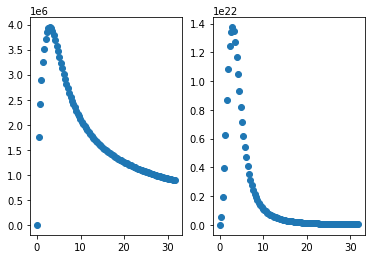

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)

ax[0].plot(radios, dat_temp, 'o' ,label='Tem_profile')
ax[1].plot(radios, dat_fluj, 'o',label='F_profile')
#ax[2].plot(radios, dat_error, 'o',label='error')

#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')

In [ ]:
# flujo electromagnetico

In [ ]:
start = time.time()
# test
rst, rout = 0.025, 31.79
mpto, me = 2e-06, 2.51e06
i = np.pi/3

nu_min, nu_max = 10, 20

values = 10**np.linspace(nu_min, nu_max, 100)

dat_f_e = np.array([])

for nu in values:
    
    fl_e = flujo_elect(nu, i, rst, rout, mpto, me)
    
    # saving
    dat_f_e = np.append(dat_f_e, fl_e)


end = time.time()
time = (end-start)/60
print(time)